In [1]:
import numpy as np
import matplotlib.pyplot as plt
import re
import gzip
import flymovie as fm

In [3]:
############################################################################
def mesh_like(arr, n):
    """Make mesh grid for last n dimensions of an array
    
    Makes a meshgrid with the same shape as the last n dimensions of input
    array-like object.
    
    Args:
        arr: array-like
            Array-like object that has a shape parameter
        n: int
            Number of dimensions, from the right, for which to make meshgrid.
    
    Returns:
        meshes: list of ndarrays
            Each element of list corresponds to ordered dimension of input,
            ndarrays are corresponding meshgrids of same shape as arr.
    """
    if (n > arr.ndim):
        raise ValueError('n is larger than the dimension of the array')
    # Make vectors of linear ranges for each dimension.
    vectors = []
    for i in reversed(range(1, n+1)):
        a = np.arange(0, arr.shape[-i])
        vectors.append(list(a))
    # Make meshgrids from vectors.
    meshes = np.meshgrid(*vectors, sparse=False, indexing='ij')
    return meshes


In [66]:
mat = np.loadtxt('/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/viewer_files/hic-72-div69-71/3R_21600000_22400000_2000.txt.gz')

(0.0, 5.0)

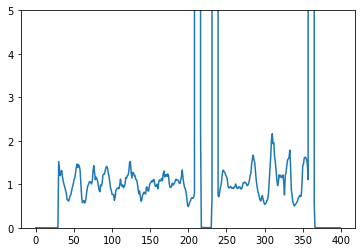

In [70]:
d = 15
y, x = mesh_like(mat, 2)
# Make a grid of distances to the diagonal, with positive values to upper right.
dist_diag = x-y
scores = np.zeros(mat.shape[0])
for n in range(d * 2, mat.shape[0] - (d * 2)):
    outter_left = mat[(x < n) & (x >= (n - (d / 2))) & (dist_diag == d)]
    outter_right = mat[(y > n) & (y <= (n + (d / 2))) & (dist_diag == d)]
    
    inner = mat[(x > n) & (y < n) & (dist_diag == d)]
    #print(np.mean(inner))
    outter = np.concatenate([outter_left, outter_right])
    score = np.mean(outter) / np.mean(inner)
    scores[n] = score

plt.plot(scores)
plt.ylim([0,5])

In [57]:
np.mean(mat)

356.4146729581737

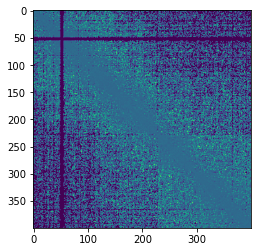

In [33]:

plt.imshow(np.log(mat + 0.001))

In [78]:
def load_track_data(trackfile_path):
        """Load genomic track data."""
        track_binsize = 500
        track_data = {}
        with gzip.open(trackfile_path, 'rt') as infile:
            for line in infile:
                items = line.split()
                (chr_, bin_, val) = items
                chr_ = re.sub('chr', '', chr_)
                
                if (chr_ not in track_data):
                    max_bin = int(4e7/ track_binsize)
                    track_data[chr_] = np.zeros(max_bin + 1000)
                bin_ = int(bin_)
                if (bin_ < len(track_data[chr_])):
                    track_data[chr_][bin_] = float(val)
        return track_data

28800 30400


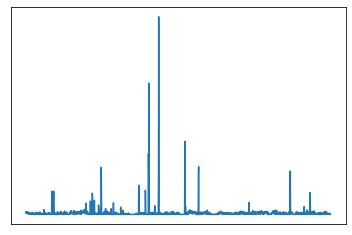

In [111]:
def plot_track(
    trackfile = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/viewer_tracks_reduced/GFP-GAF-1.txt.gz',
    outfile = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/hic-69-71/GAF_3R_14400000_15200000.png',
    chr_ = '3R',
    start = 14400000,
    end = 15200000,
    binsize = 500
    ):

    startbin = int(start / binsize)
    endbin = int(end / binsize)
    print(startbin, endbin)

    track = load_track_data(trackfile)
    plt.plot(track[chr_][startbin:(endbin+1)])
    plt.xticks([])
    plt.yticks([])
    plt.savefig(outfile, dpi=300)

plot_track()

28800 30400


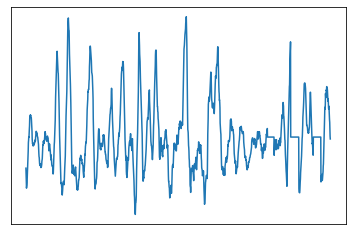

In [113]:
plot_track(trackfile='/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic-72/hic72_CompressedBinCounts_500bp_3R_test_weightedDirectionality_w1000d1a1.0_boundarieScore_w20.txt.gz', outfile='/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/hic-72/BS_3R_14400000_15200000.png')

28800 30400


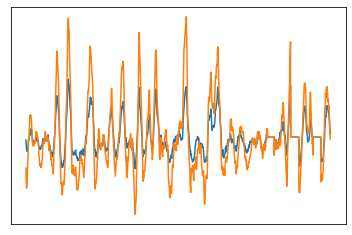

In [105]:
def plot_track2(
    trackfile1 = '/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic-69-71/hic69-71_CompressedBinCounts_500bp_3R_test_weightedDirectionality_w1000d1a1.0_boundarieScore_w20.txt.gz',
    trackfile2 = '/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic-72/hic72_CompressedBinCounts_500bp_3R_test_weightedDirectionality_w1000d1a1.0_boundarieScore_w20.txt.gz',
    outfile = '/Users/michaelstadler/Bioinformatics/Projects/insulators/viewer_data/saves/hic-69-71/GAF_3R_14400000_15200000.png',
    chr_ = '3R',
    start = 14400000,
    end = 15200000,
    binsize = 500
    ):

    startbin = int(start / binsize)
    endbin = int(end / binsize)
    print(startbin, endbin)

    track1 = load_track_data(trackfile1)
    track2 = load_track_data(trackfile2)
    plt.plot(track1[chr_][startbin:(endbin+1)])
    plt.plot(track2[chr_][startbin:(endbin+1)])
    plt.xticks([])
    plt.yticks([])
    #plt.savefig(outfile, dpi=300)

plot_track2()

In [72]:
from sklearn.decomposition import PCA

def norm_hc(mat):
    mat2 = mat.copy()
    mat2 = mat2 / (mat.mean(axis=0) + 1) * 1000
    mat2 = mat2.T
    mat2 = mat2 / (mat.mean(axis=1) + 1) * 1000
    mat2 = mat2.T
    return mat2

def distnorm(mat):
    x,y = fm.mesh_like(mat, 2)
    distmesh = y - x
    distmeans = np.zeros_like(mat)
    for n in range(np.max(distmesh)):
        distmean = np.mean(mat[distmesh == n])
        distmeans[distmesh == n] = distmean
        distmeans[distmesh == (-1 * n)] = distmean
    
    distmeans = distmeans + 0.001
    return (mat / distmeans) * 1000


def pca_mat(distnorm):
    cov = np.cov(distnorm)
    centered = (cov - np.mean(cov)) / np.std(cov)
    pct99 = np.percentile(centered, 99)
    pct1 = np.percentile(centered, 1)
    centered[centered > pct99] = pct99
    centered[centered < pct1] = pct1
    pca = PCA(n_components=2)
    pca.fit(centered)
    print(pca.explained_variance_ratio_)
    X = pca.transform(centered)
    return centered, X
    

def plot_comp(cov, pca, vmax=None):
    if vmax == None:
        vmax = np.max(cov)
    fig = plt.figure(constrained_layout=True)
    subfigs = fig.subfigures(2, 1, wspace=0.07, height_ratios=[1, 4.])
    axs0 = subfigs[0].subplots()
    #comp = np.where(pca[:,0] < 0, 1, 0)
    #axs0.plot(comp)
    axs0.plot(pca[:,0])
    axs0.margins(x=0)
    axs0.set_yticklabels([])
    axs0.set_xticklabels([])
    axs0.set_xticks([])
    axs1 = subfigs[1].subplots()
    axs1.imshow(cov, vmax=vmax, aspect="auto")
    axs1.set_yticklabels([])
    axs1.margins(x=0)
    plt.tight_layout

[0.90784302 0.0185743 ]


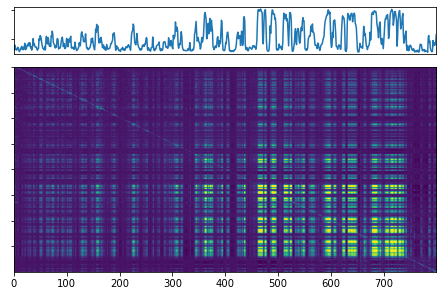

In [74]:
#m = np.loadtxt('/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic42-2L-100kb.txt_binCounts_100kB.txt')
m = np.loadtxt('/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic42-2L-25kb.txt_binCounts_25kB.txt')
m = norm_hc(m)
d = distnorm(m)
d = d[:800, :800]
centered, X = pca_mat(d)
plot_comp(centered, X)

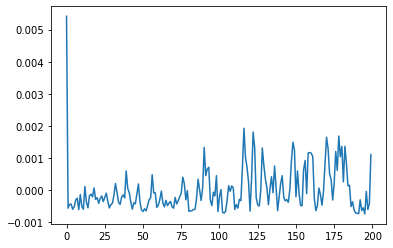

In [62]:
plt.plot(X[:,0])

In [22]:
def distnorm(mat):
    x,y = fm.mesh_like(mat, 2)
    distmesh = y - x
    distmeans = np.zeros_like(mat)
    for n in range(np.max(distmesh)):
        distmean = np.mean(mat[distmesh == n])
        distmeans[distmesh == n] = distmean
        distmeans[distmesh == (-1 * n)] = distmean
    
    distmeans = distmeans + 0.001
    return (mat / distmeans) * 1000

#m = np.loadtxt('/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic42-2L-100kb.txt_binCounts_100kB.txt')
m = np.loadtxt('/Users/michaelstadler/Bioinformatics/Projects/insulators/outputs/hic42-2L-25kb.txt_binCounts_25kB.txt')

d = np.cov(distnorm(m))
d = (d - np.median(d)) / np.std(d) * 100
fm.viewer(d, 5)

interactive(children=(Dropdown(description='Color', index=2, options=('Greens', 'Reds', 'cividis', 'Gators', '…

In [ ]:
pca_mat()